# Определение стоимости автомобилей

Я работаю над разработкой приложения для продажи автомобилей с пробегом для компании "Не бит, не крашен". Моя задача - создать модель, которая позволит быстро определить рыночную стоимость автомобиля на основе исторических данных о технических характеристиках, комплектации и ценах автомобилей.

Для заказчика очень важно, чтобы модель имела высокое качество предсказаний, быстро работала и требовала минимального времени для обучения. Я уделяю максимальное внимание этим требованиям, чтобы наше приложение было максимально удобным и функциональным для пользователей.

Признаки  
`DateCrawled` — дата скачивания анкеты из базы  
`VehicleType` — тип автомобильного кузова  
`RegistrationYear` — год регистрации автомобиля  
`Gearbox` — тип коробки передач  
`Power` — мощность (л. с.)  
`Model` — модель автомобиля  
`Kilometer` — пробег (км)  
`RegistrationMonth` — месяц регистрации автомобиля  
`FuelType` — тип топлива  
`Brand` — марка автомобиля   
`Repaired` — была машина в ремонте или нет  
`DateCreated` — дата создания анкеты  
`NumberOfPictures` — количество фотографий автомобиля  
`PostalCode` — почтовый индекс владельца анкеты (пользователя)  
`LastSeen` — дата последней активности пользователя  
Целевой признак  
`Price` — цена (евро)  

## Подготовка данных

### Импорт библиотек и загрузка данных

In [1]:
!pip3 install phik
!pip install catboost
!pip install optuna

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import catboost as cb


from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')

In [3]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except FileNotFoundError:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
data.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
238879,2016-03-21 09:57:16,50,small,1996,manual,45,1_reihe,150000,6,petrol,peugeot,no,2016-03-21 00:00:00,0,6809,2016-03-21 10:39:55
30012,2016-03-21 17:44:48,8400,sedan,2010,manual,95,a_klasse,70000,9,petrol,mercedes_benz,no,2016-03-21 00:00:00,0,14974,2016-04-02 18:18:06
217421,2016-04-01 17:57:12,5999,convertible,1996,manual,192,spider,90000,8,petrol,alfa_romeo,no,2016-04-01 00:00:00,0,30952,2016-04-05 13:45:00
51274,2016-03-20 11:38:54,2699,NaN,2017,manual,0,golf,150000,3,NaN,volkswagen,no,2016-03-20 00:00:00,0,73035,2016-04-06 08:46:37
231729,2016-03-25 14:48:00,450,NaN,2016,auto,136,omega,150000,0,NaN,opel,NaN,2016-03-25 00:00:00,0,15713,2016-04-06 17:47:06


##### Промежуточный итог

Данные корректно загружены, необходимые библиотеки загружены, данные представляют из себя цифры и буквы

### Изучение данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

#### convert_to_python_case

приведу названия колонок к нижнему регистру

In [5]:
def convert_to_python_case(text):
    s = ''
    for el in text:
        if el.isupper():
            s += '_'
        s += el.lower()
    return s[1:]
data.columns = [convert_to_python_case(i) for i in data.columns]

#### Удаление колонок number_of_pictures, registration_month, postal_code, date_created, last_seen

удалю заведомо бесполезные, как я считаю, колонки для предсказания модели
здесь и количество фото в объявлении, почтовый код. возможно, что почтовый код может понадобится для локализации места продажи, а последняя дата обновления для актуализации ценника, но для настоящей задачи считаю это излишним

In [6]:
data = data.drop(['number_of_pictures', 'registration_month', 'postal_code', 'date_created', 'last_seen'], axis=1)
data.sample(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
349095,2016-03-24 19:49:49,1900,sedan,2004,manual,116,mondeo,150000,gasoline,ford,no
102141,2016-04-03 17:56:04,800,wagon,1994,manual,115,NaN,150000,petrol,volkswagen,no
181796,2016-03-31 20:49:36,120,sedan,1990,manual,113,3er,150000,petrol,bmw,yes
89407,2016-03-13 09:46:38,100,small,1999,manual,101,astra,150000,petrol,opel,yes
200552,2016-03-23 18:56:06,0,other,2006,manual,0,NaN,20000,other,sonstige_autos,yes
138000,2016-03-08 10:52:15,444,small,1991,manual,90,golf,150000,petrol,volkswagen,yes
246961,2016-03-30 23:54:37,180,NaN,2000,manual,60,corsa,150000,NaN,opel,yes
110816,2016-03-18 16:41:36,800,wagon,1994,manual,136,omega,150000,petrol,opel,NaN
332041,2016-04-02 20:56:00,5300,coupe,1996,manual,400,golf,150000,petrol,volkswagen,no
219421,2016-03-14 07:59:10,8800,NaN,2017,manual,110,eos,80000,petrol,volkswagen,no


#### replacment

назову машины только бензиновыми и газовыми, почему то нет дизельных, это довольно важно для ценообразования. Електромобилей не так много, соединил их вместе с гибридами

In [7]:
replacements = {'gasoline': 'petrol', 'lpg': 'cng', 'electric': 'other', 'hybrid': 'other' }
data['fuel_type'] = data['fuel_type'].replace(replacements)
data.fuel_type.value_counts()

petrol    315072
cng         5875
other        527
Name: fuel_type, dtype: int64

#### доли пропусков в данных

посчитаю доли пропусков, где они есть

In [8]:
x = data.isna().mean().where(data.isna().mean() > 0).dropna().round(4)*100
x

vehicle_type    10.58
gearbox          5.60
model            5.56
fuel_type        9.28
repaired        20.08
dtype: float64

постараюсь узнать побольше про пропуски и что с ними можно делать

In [9]:
list_of_isna =[]
for i in data[['gearbox', 'model', 'fuel_type', 'repaired']]:
    print(data[f'{i}'].value_counts())
    print()
    print(data[f'{i}'].isna().value_counts())
    list_of_isna.append(data[f'{i}'].isna().value_counts())
    print('***' * 10)
    print(end='\n')

manual    268251
auto       66285
Name: gearbox, dtype: int64

False    334536
True      19833
Name: gearbox, dtype: int64
******************************

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
rangerover                4
serie_3                   4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 250, dtype: int64

False    334664
True      19705
Name: model, dtype: int64
******************************

petrol    315072
cng         5875
other        527
Name: fuel_type, dtype: int64

False    321474
True      32895
Name: fuel_type, dtype: int64
******************************

no     247161
yes     36054
Name: repaired, dtype: int64

False    283215
True      71154
Name: repaired, dtype: int64
******************************



#### boxplot

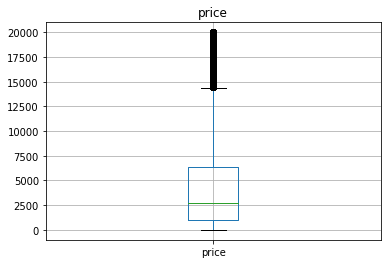

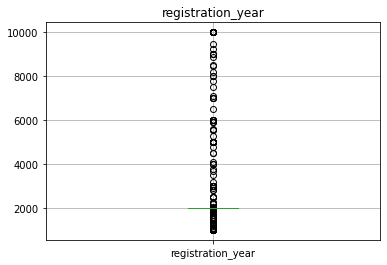

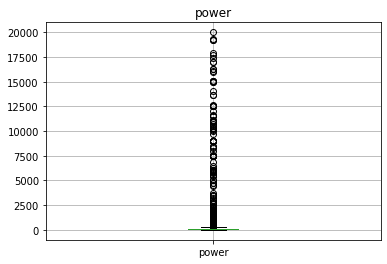

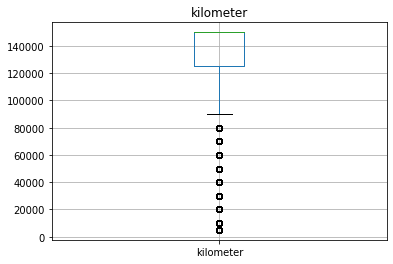

In [12]:
import matplotlib.pyplot as plt
num_cols = list(data.select_dtypes(include=['float64', 'int64']).columns)


for col in num_cols:
    plt.figure()
    data.boxplot([col])
    plt.title(col)
    plt.show()

везде есть выбросы, но в частично данные смещены к нулю, что считаю некорректным

<AxesSubplot:>

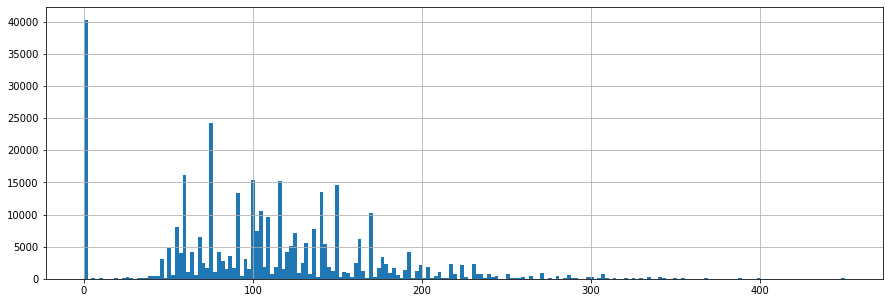

In [13]:
data.power.hist(bins=200, range=(0, 450), figsize=(15, 5))

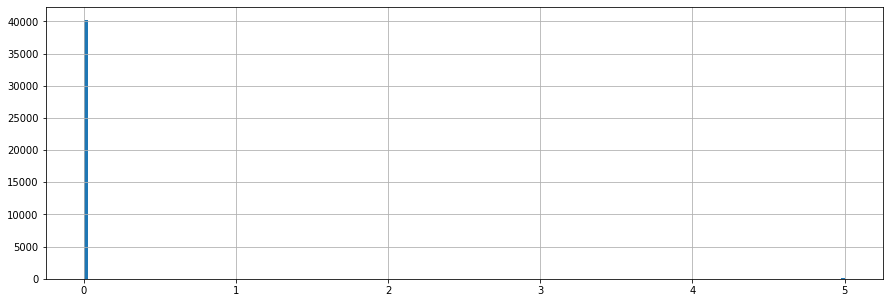

In [14]:
data.power.hist(bins=200, range=(0, 5), figsize=(15, 5));

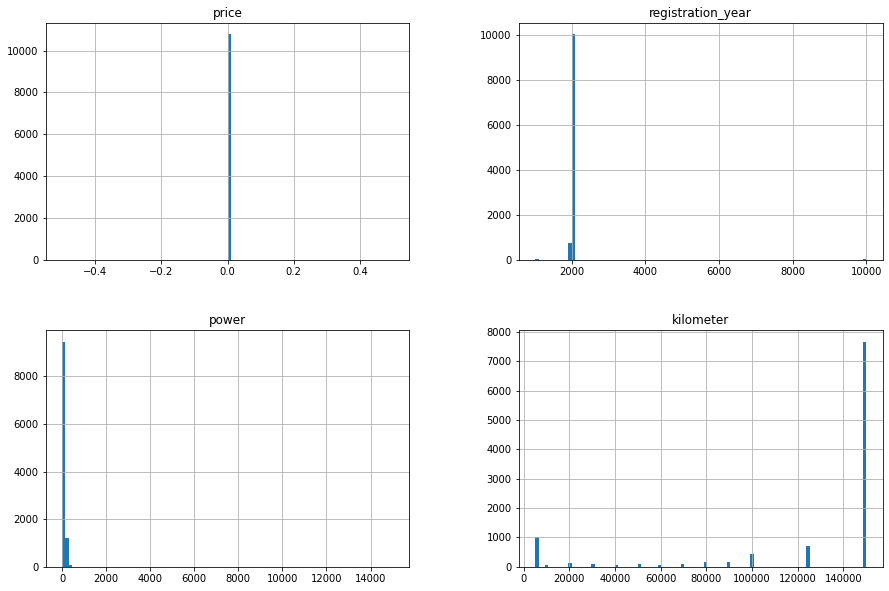

In [15]:
result_df = data.loc[data.price == 0]

result_df.hist(figsize=(15,10), bins=100);

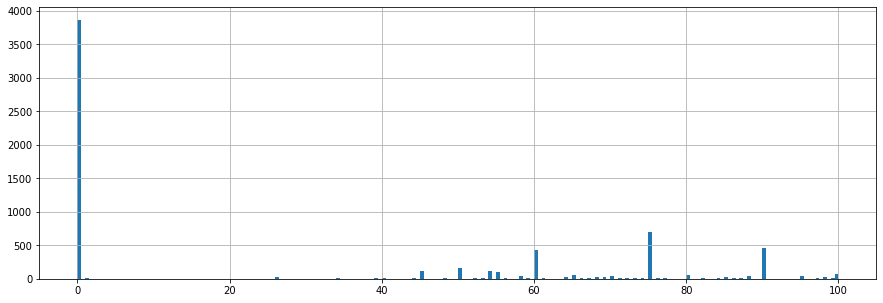

In [16]:
result_df.power.hist(bins=200, range=(0, 100), figsize=(15, 5));

считаю, что нулевые значения точно не помогут в выполнении задачи, а заполнять их средним или медианной некорректно, поэтому удалю

In [17]:
data.drop(data[data.price == 0].index, inplace=True)
data.drop(data[data.power == 0].index, inplace=True)

еще раз посмотрим на пропущенные значения и приступим к предобработке

In [18]:
missing_values = data.isnull().sum()

missing_columns = missing_values[missing_values > 0]

for column in missing_columns.index:
    print("Столбец:", column)
    print("Описание:")
    print(data[column].describe())
    print('Пропущено значений:')
    print(data[column].isnull().sum())
    print("\n")


Столбец: vehicle_type
Описание:
count     285837
unique         8
top        sedan
freq       83172
Name: vehicle_type, dtype: object
Пропущено значений:
21400


Столбец: gearbox
Описание:
count     301128
unique         2
top       manual
freq      240694
Name: gearbox, dtype: object
Пропущено значений:
6109


Столбец: model
Описание:
count     294743
unique       249
top         golf
freq       26031
Name: model, dtype: object
Пропущено значений:
12494


Столбец: fuel_type
Описание:
count     287408
unique         3
top       petrol
freq      281730
Name: fuel_type, dtype: object
Пропущено значений:
19829


Столбец: repaired
Описание:
count     260043
unique         2
top           no
freq      230261
Name: repaired, dtype: object
Пропущено значений:
47194




#### Итог по изучению данных

Данные загружены и изучены

Есть пропуски, в некоторых колонках до  20%

Удалены заведомо неинформативные колонки

Построен график корреляции Phik

Построены графики boxplot, выявлены паразитные значения и выбросы

### Заполнение пропусков, обработка аномалий

#### Registration_year

совершенно не правдоподобные уникальные значения года регистрации(выпуска?)
это один из ключевых параметров, считаю нужным отсечь лишнее

In [19]:
data.date_crawled.max()

'2016-04-07 14:36:58'

In [20]:
data.registration_year.unique()


array([2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 2016, 2007, 2009,
       2002, 2018, 1997, 1990, 2017, 1981, 2003, 1991, 1984, 2006, 1999,
       2012, 1994, 2010, 2000, 1992, 2013, 1996, 1989, 2015, 1993, 1985,
       1982, 1983, 1973, 1969, 1971, 1987, 1988, 1980, 1970, 1986, 1976,
       1965, 1945, 1974, 1955, 1978, 1979, 1972, 1977, 1961, 1975, 1968,
       1963, 1966, 1964, 1958, 1959, 1956, 1941, 1960, 1500, 1962, 1929,
       1957, 1910, 1940, 1967, 1949, 1937, 1800, 1953, 2019, 1954, 1234,
       2900, 6000, 5911, 1400, 5000, 4000, 8000, 1932, 1951, 1952, 1950,
       4800, 1942, 1935, 6500, 1923, 1000, 1930, 9999, 1943, 1938, 1936,
       1928, 3000, 2800, 1931, 1948, 4500, 1927, 1933, 8200, 1947, 1944,
       1600])

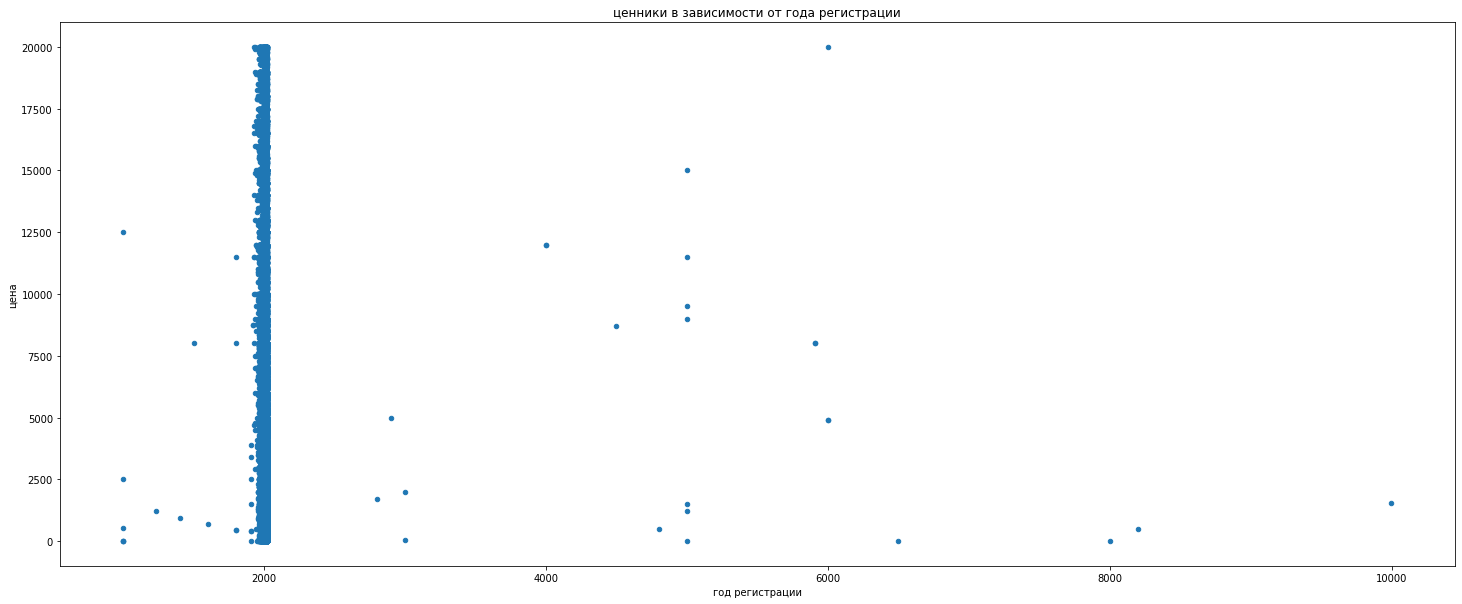

In [21]:
data.plot(x='registration_year', y='price', kind='scatter')

plt.xlabel('год регистрации')
plt.ylabel('цена')
plt.title('ценники в зависимости от года регистрации')
plt.gcf().set_size_inches(25, 10)

plt.show()

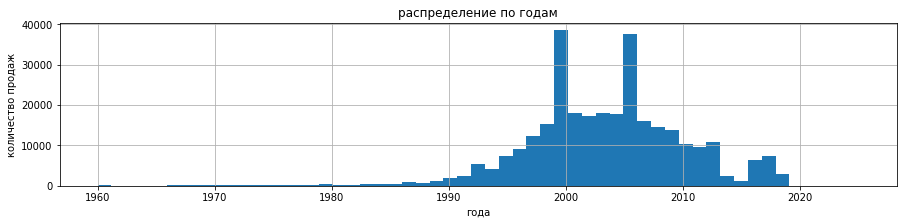

In [22]:
data.registration_year.hist(bins = 55, figsize = (15,3), range=(1960, 2025));
plt.xlabel("года")
plt.ylabel("количество продаж")
plt.title('распределение по годам');

последнее зарегестрированное объявление было '2016-04-07 14:36:58', чтобы не заморачиваться с месяцами, ограничу верхнюю планку 2017 годом

удалю все объявления старше 1950 и после 2017, как неправдободные

In [23]:
data = data.drop(['date_crawled'], axis = 1)
data.loc[data['registration_year'] > 2016] = 0
data.loc[data['registration_year'] < 1950] = 0

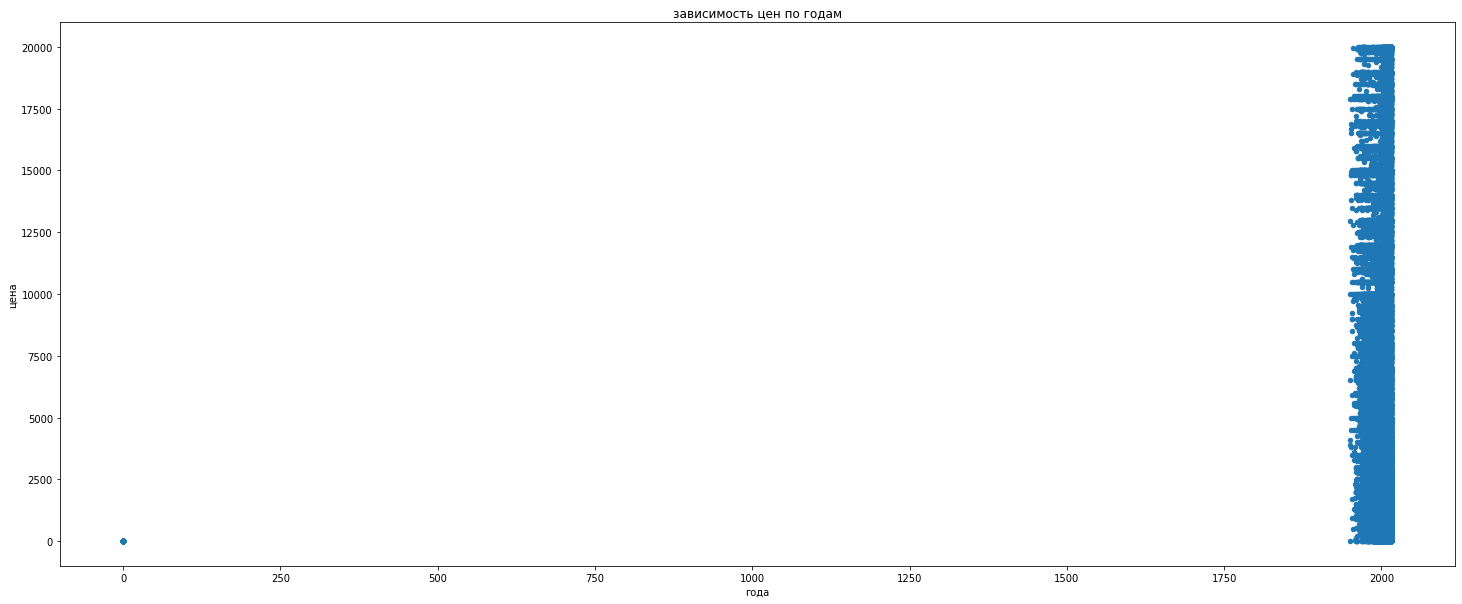

In [24]:
data.plot(x='registration_year', y='price', kind='scatter')

plt.xlabel('года')

plt.ylabel('цена')
plt.title('зависимость цен по годам')
plt.gcf().set_size_inches(25, 10)
plt.show()

In [25]:
data.drop(data[data.price == 0].index, inplace=True)
data.drop(data[data.registration_year == 0].index, inplace=True)

In [26]:
data.registration_year.value_counts()

1999    19609
2005    18936
2000    18823
2006    18587
2003    17965
        ...  
1953        8
1951        8
1957        8
1950        7
1952        4
Name: registration_year, Length: 67, dtype: int64

#### Price

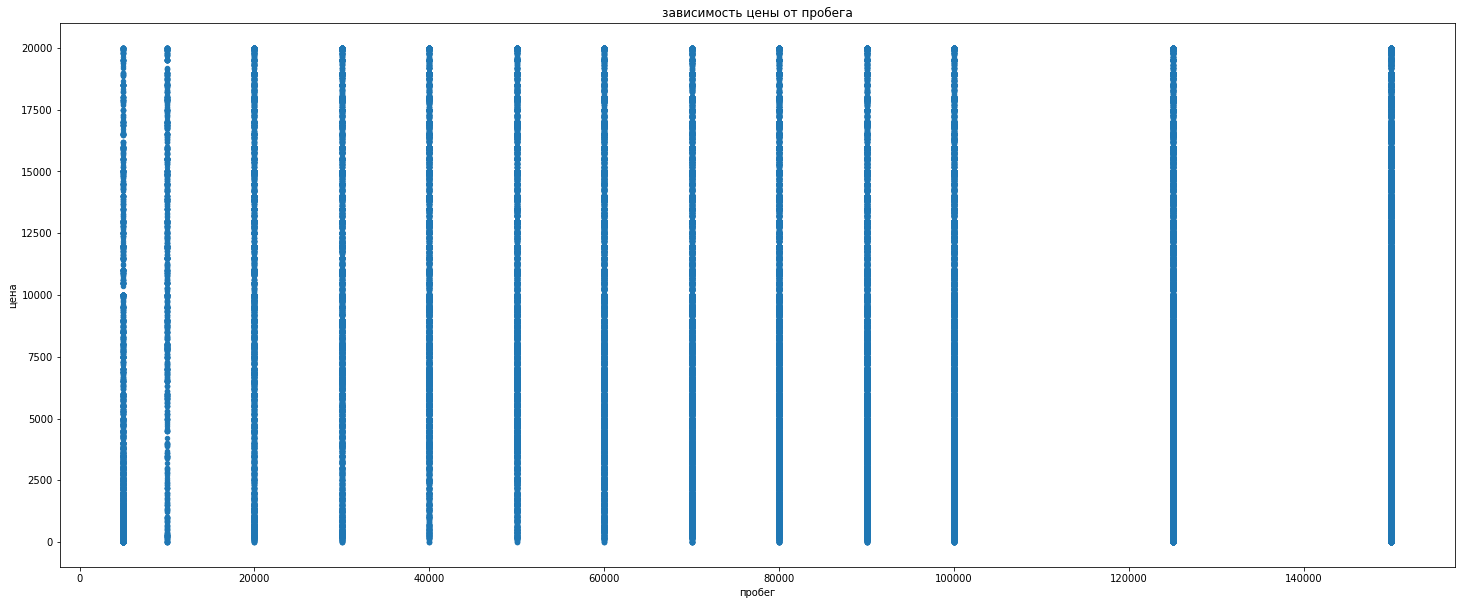

In [27]:
data.plot(x='kilometer', y='price', kind='scatter')

plt.xlabel('пробег')
plt.ylabel('цена')
plt.title('зависимость цены от пробега')
plt.gcf().set_size_inches(25, 10)

plt.show()  

#### Repaired

постараюсь побороться с самой запущенной по пропускам колонке, переименную категории, посмотрю распредление и удалю лишнее


In [28]:
data['repaired'] = data['repaired'].replace({'yes': '1', 'no': '0', '0':'0'})
data.repaired

1           1
2         NaN
3           0
4           0
5           1
         ... 
354361      0
354362      1
354366      0
354367      0
354368    NaN
Name: repaired, Length: 296852, dtype: object

In [29]:
data.repaired.value_counts()

0    224811
1     28985
Name: repaired, dtype: int64

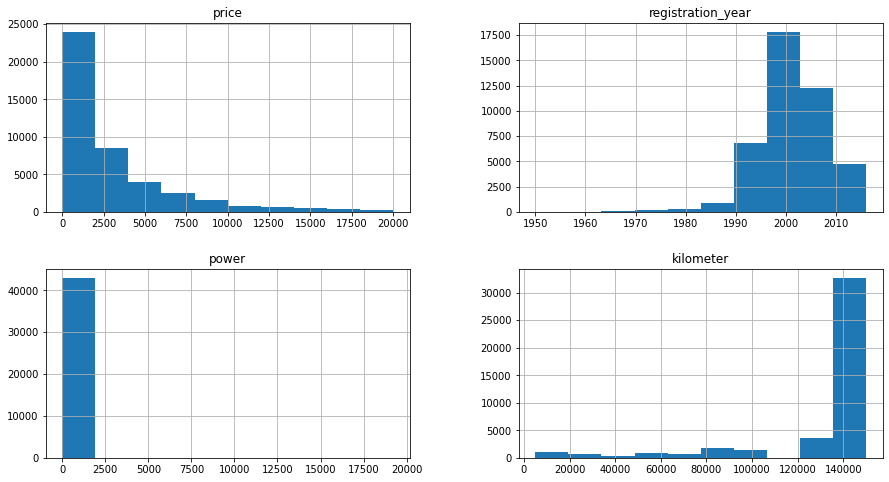

In [30]:
df_with_nan = data.loc[data['repaired'].isnull()]
df_with_nan.hist(figsize=(15,8));

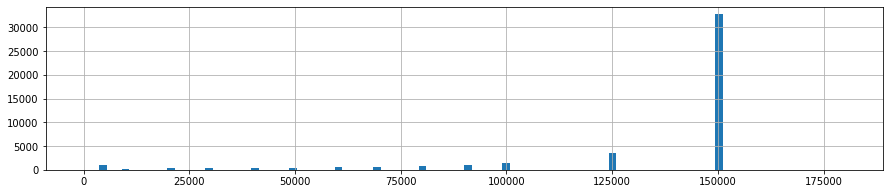

In [31]:
df_with_nan.kilometer.hist(bins = 100, figsize = (15,3), range=(0, 180000));

In [32]:
data.repaired = data.repaired.replace(np.nan, 'unknown')
data.repaired.value_counts()

0          224811
unknown     43056
1           28985
Name: repaired, dtype: int64

#### Gearbox

пропущенные данные есть, но отнесем их в неизвестные, их немного, на модель не должны сильно повлиять

In [33]:
data.gearbox = data.gearbox.replace(np.nan, 'unknown')
data.gearbox = data.gearbox.replace(0, 'unknown')
data.gearbox.value_counts()

manual     232445
auto        59008
unknown      5399
Name: gearbox, dtype: int64

#### Power

довольно значимый признак при продаже, но показатели в 20т.л.с или в 0 л.с. не могут не настораживать, как некорректные
признаю допустимым, что гражданское авто может иметь 300 и даже 400 л.с., но я был бы не прочь, при возможности, приобрести и довольно быстрый авто, поэтму поднял планку в 500 л.с. Все что выше - спортивные болиды и должны оцениваться индивидуально, тем более что квантиль в 0.98 показывает 260 л.с.

In [34]:
data.power.describe()

count    296852.000000
mean        124.295157
std         190.818212
min           1.000000
25%          75.000000
50%         111.000000
75%         150.000000
max       20000.000000
Name: power, dtype: float64

In [35]:
print(data.power.quantile(0.98))
print(data.power.quantile(.04))

265.0
54.0


In [36]:
data.drop(data[data.power > 500].index, inplace=True)
data.drop(data[data.power < 15].index, inplace=True)

In [37]:
data.power.describe()

count    296177.000000
mean        120.607299
std          53.467408
min          15.000000
25%          75.000000
50%         111.000000
75%         150.000000
max         500.000000
Name: power, dtype: float64

#### Model

здесь анализ недолгий, если нет названия модели - относим к неизвестному, главное что в брендах у нас нет пропусков

In [38]:
data.model = data.model.replace(np.nan, 'unknown')

In [39]:
x = data.isna().mean().where(data.isna().mean() > 0).dropna().round(4)*100
x

vehicle_type    3.72
fuel_type       5.24
dtype: float64

#### Vehicle Type

In [40]:
data.vehicle_type = data.vehicle_type.replace(np.nan, 'unknown')
data.fuel_type = data.fuel_type.replace(np.nan, 'unknown')
data.reset_index(drop=True)
print(data.vehicle_type.astype(str))


1               coupe
2                 suv
3               small
4               small
5               sedan
             ...     
354361        unknown
354362          sedan
354366    convertible
354367            bus
354368          wagon
Name: vehicle_type, Length: 296177, dtype: object


#### Итог по заполнению и обработке

Были обработаны пропуски, большей частю заменены на категорию unknown

Аномалии убраны, т.к. их замена может повлиять на итог работы. Считаю возможным восстановление данных, по другим данным, но контекст работы это не предполагает

### Подготовка к обучению

ооооочень долгое время было потрачено на ту недоработку, что некоторые категориальные колонки имели, почему то, целочисленные значения. возможно, они закрались по ошибке, поэтому обрабатываю их в начале и удостоверяюсь, что ничего лишнего нет

In [41]:
data=data.reset_index(drop=True)
df = data.copy()
col = df.select_dtypes(include=['object']).columns

for i in df[col]:
  df[i] = df[i].astype(str)
  print(df[i].unique())

  
features = df.drop('price', axis=1)
target = df.price

['coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'unknown'
 'other']
['manual' 'auto' 'unknown']
['unknown' 'grand' 'golf' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe'
 'passat' 'navara' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er' 'arosa'
 'other' 'civic' 'transporter' 'punto' 'e_klasse' 'clio' 'kadett' 'one'
 'fortwo' '1er' 'b_klasse' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito'
 'sprinter' 'astra' '156' 'escort' 'forester' 'xc_reihe' 'scenic' 'ka'
 'a1' 'focus' 'a4' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' 'combo' 'corsa'
 '80' '147' 'z_reihe' 'sorento' 'ibiza' 'mustang' 'eos' 'touran' 'getz'
 'insignia' 'almera' 'megane' 'a3' 'lupo' 'r19' 'caddy' 'mondeo' 'cordoba'
 'colt' 'impreza' 'vectra' 'berlingo' 'tiguan' '6_reihe' 'c4' 'panda' 'up'
 'i_reihe' 'ceed' 'kangoo' '5_reihe' 'yeti' 'octavia' 'zafira' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'rio' 'touareg' 'logan'
 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's_klasse' '1_reihe'
 'sharan' 'avensis' 'rooms

разбивка по выборкам и кодировка для эксперимента над моделями RandomForest и LinearRegression

In [42]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)
features_test, features_val, target_test, target_val = train_test_split(features_test, target_test, test_size=0.5, random_state=12345)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=12345)
X_train, X_val, y_train, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=12345)

In [43]:
cat_features = ['vehicle_type','brand','model', 'fuel_type', 'gearbox', 'repaired']
encoder = OrdinalEncoder()
encoder.fit(features_train[cat_features])

features_test_oe= pd.DataFrame(encoder.transform(features_test[cat_features]))
features_train_oe= pd.DataFrame(encoder.transform(features_train[cat_features]))
features_val_oe = pd.DataFrame(encoder.transform(features_val[cat_features]))
target_val_oe = target_val.copy()
target_train_oe = target_train.copy()
target_test_oe = target_test.copy()

features_train_oe
features_test_oe

,0,1,2,3,4,5
0,4.0,2.0,15.0,3.0,0.0,1.0
1,4.0,24.0,42.0,2.0,1.0,0.0
2,5.0,10.0,128.0,2.0,1.0,0.0
3,0.0,27.0,198.0,2.0,1.0,0.0
4,8.0,38.0,170.0,2.0,1.0,0.0
...,...,...,...,...,...,...
29613,4.0,1.0,28.0,2.0,1.0,0.0
29614,5.0,38.0,143.0,2.0,1.0,0.0
29615,5.0,32.0,106.0,2.0,1.0,1.0
29616,6.0,24.0,166.0,2.0,1.0,0.0


In [44]:
features_ohe = pd.get_dummies(features, drop_first=True)

features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(features_ohe, target, test_size=.25,random_state=12345)
features_test_ohe, features_val_ohe, target_test_ohe, target_val_ohe = train_test_split(features_test_ohe, target_test_ohe, test_size=0.5, random_state=12345)

features_val_ohe

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_unknown,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_1,repaired_unknown
106219,2003,105,150000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
134583,2002,192,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
194482,2014,116,70000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10031,2004,150,150000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67277,2010,110,100000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234747,1995,86,125000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
295318,2000,116,150000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
166470,2009,140,80000,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
82791,2009,143,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Обучение моделей

Дальнейшие ячейки будут иметь вид ---

обучение модели

предсказание 

с выводом времени и метрики RMSE на тестовой выборке

Далее все переменные сохранены в конечную таблицу и проведен анализ этих данных

### LR



In [45]:
import time

In [46]:


%%time
start_time = time.time()
model_lr = LinearRegression()
model_lr.fit(features_train_ohe, target_train_ohe)
rmse_lr_ohe = ((cross_val_score(model_lr, features_train_ohe, target_train_ohe, cv=5, scoring='neg_mean_squared_error')).mean() * -1) ** .5
end_time = time.time()
LR_time_train= end_time - start_time


CPU times: user 44 s, sys: 46.6 s, total: 1min 30s
Wall time: 1min 32s


In [47]:
%%time
start = time.time()
target_predict = model_lr.predict(features_val_ohe)
rmse_lr_ohe2 = mean_squared_error(target_val_ohe, target_predict) ** .5
end = time.time()
LR_time_pred=round(end-start,2)

CPU times: user 130 ms, sys: 114 ms, total: 245 ms
Wall time: 281 ms


### RF

In [48]:
# %%time
# start_time = time.time()
# RF = RandomForestRegressor(criterion = "mse",random_state=42,n_estimators = 50,n_jobs=-1)
# RF.fit(features_train_oe, target_train_oe)
# end_time = time.time()
# RF_time_train = end_time - start_time

In [49]:
%%time
start = time.time()
model_rf = RandomForestRegressor(random_state=12345, criterion='mse',warm_start=False, n_estimators=100, n_jobs=-1)
model_rf.fit(features_train_oe, target_train_oe)
cvs_rmse_rf = ((cross_val_score(model_rf, features_train_oe, target_train_oe, cv=5, scoring='neg_mean_squared_error')).mean() * -1) ** .5
end = time.time()
RF_time_cv_train=round(end-start,2)

CPU times: user 1min 39s, sys: 1.35 s, total: 1min 40s
Wall time: 1min 43s


In [50]:
%%time
start = time.time()
pred_rf=model_rf.predict(features_val_oe)
RF_cv_rmse_test = mean_squared_error(target_test_oe,model_rf.predict(features_test_oe),squared=False)
end = time.time()
RF_cv_time_test=round(end-start,2)

CPU times: user 1.06 s, sys: 5.05 ms, total: 1.07 s
Wall time: 1.07 s


### CAT

In [54]:
%%time
start = time.time()
parameters = [{'learning_rate':[.1, .5, .8], 'random_state':[12345], 'verbose':[False]}]
model_cat = cb.CatBoostRegressor(random_state=123,learning_rate=0.4,cat_features=cat_features, verbose=10,n_estimators=100)
model_cat = GridSearchCV(model_cat, parameters, scoring='neg_mean_squared_error')
model_cat.fit(X_train, y_train, eval_set=(X_test,y_test))
CB_cv_rmse = ((cross_val_score(model_cat, X_train, y_train, cv=5, scoring='neg_mean_squared_error')).mean() * -1) ** .5
end = time.time()
CB_cv_time=round(end-start,2)


CPU times: user 1min 38s, sys: 3.16 s, total: 1min 41s
Wall time: 2min 32s


In [55]:
%%time
start = time.time()
y_pred = model_cat.predict(X_val)
CB_cv_rmse_val = mean_squared_error(y_val, y_pred, squared=False) 
end = time.time()
CB_cv_time_test=round(end-start,2)


CPU times: user 44.2 ms, sys: 156 µs, total: 44.4 ms
Wall time: 42.9 ms


на всякий случай перегружу переменные, очень долго считается LGBM

In [56]:
del X_train, y_train, X_test, y_test, features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe, features_train, features_test, target_train, target_test

### LGBM

In [57]:

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=12345)

cat_feature_names = X_train.select_dtypes("object").columns

X_train[cat_feature_names] = X_train[cat_feature_names].astype("category")
X_test[cat_feature_names] = X_test[cat_feature_names].astype("category")

In [58]:
cat_features = ['vehicle_type', 'gearbox', 'model', 'brand', 'repaired', 'registration_year', 'fuel_type']

params = {"iterations": 20,
          "learning_rate": 1,
          "max_depth": None,
          "loss_function": "RMSE",
          "random_state": 12345,
          "bootstrap_type": 'gbdt',
          "min_data_in_leaf": 1
          }

lgbm_train_data = lgb.Dataset(X_train, label=y_train)
arguments = {'learning_rate': 1,
         'metric': 'rmse',
         'seed': 12345,
         'objective': 'regression',
         'verbosity': -1,
        }


max_depth = [3, 6, 12]

In [ ]:
%time
best_score = 5000
best_depth = 0
for depth in max_depth:
    arguments['max_depth'] = depth
    score = lgb.cv(arguments, lgbm_train_data, nfold=3, categorical_feature=cat_features)
    score = pd.DataFrame(score).iloc[-1]['rmse-mean']
    if score < best_score:
        best_score = score
        best_depth = depth
        
best_score, best_depth


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.11 µs


In [ ]:
%%time
start = time.time()
params['max_depth'] = best_depth
lgbm_model = lgb.train(arguments, lgbm_train_data, categorical_feature=cat_features, num_boost_round=1000)
LGBM_rmse = cross_val_score(lgbm_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
end = time.time()
LGBM_time=round(end-start,2)

In [ ]:
%%time
start = time.time()
#predict_LGB= lgbm_model.predict(X_tes,pred_contrib=True)
LGBM_rmse2 = mean_squared_error(y_test,lgbm_model.predict(X_test),squared=False)
end = time.time()
LGBM_time_test=round(end-start,2)

## Анализ моделей

Все данные по работе моделей занесены в таблицу и приведены ниже 

красным отмечен нижний показатель в необохдимой метрике, зеленым лучший

In [ ]:
column=['RMSE','Скорость обучения','Скорость предсказания']

tabl = pd.DataFrame(index=['RMSE','Скорость обучения', 'Скорость предсказания'], columns=['LinearRegression', 'RandomForestRegressor_CV', 'CatBoostRegressor_CV','LightGBM'])
tabl['LinearRegression'] = rmse_lr_ohe, LR_time_train, LR_time_pred
tabl['RandomForestRegressor_CV'] = cvs_rmse_rf, RF_time_cv_train, RF_cv_time_test
tabl['CatBoostRegressor_CV'] = CB_cv_rmse, CB_cv_time, CB_cv_time_test
tabl['LightGBM'] = LGBM_rmse, LGBM_time, LGBM_time_test

tabl.T.style.highlight_min(color='green',subset=column).highlight_max(color='red',subset=column)

Лучшей по компромиссным данным ----

не высокое RMSE, не самая высокая скорость обучения, но быстрая скорость предсказания стала модель CatBoostRegressor


на тесте ошибка RMSE составляет-----

In [ ]:

y_pred = model.predict(X_test)
CB_rmse_test = mean_squared_error(y_test, y_pred, squared=False) 
CB_rmse_test

### Итог

Была проведена загрузка данных и их обработка

В данных присутствуют пропуски и незаполненные данные. В целом не считаю это проблемой и нахожу возможным к заполнению их по другим признакам. Для этого нужно написать отдельный параграф в работе и провести дополнительную иследовательскую работу

К этапу обучения моделей были выбраны модели линейной регрессии, случайный лес, кэтбуст и лайтГБМ. Для некторых моделей были закодированы данные и применен гридсерч, но это не спасло общей ситуации и модели показали недостаточный уровень метрики.

Для более объективного итога возможно составление общего рейтинга, но как его почитать, не нахожу мыслей

Лучшей моделью себя показала модель CatBoost, как по времени предсказания, так и по лучшей ошибке RMSE. LightGBM хоть и быстро учится и имеет невысокую ошибку, но время предсказания самое большое и это считаю критичным.

Поэтому для заказчика считаю возомжным рекомендовать модель CatBoost